# Combine social histories of each patient into a unified record

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xml.etree.ElementTree as ET
import re



from google.colab import drive
drive.mount('/content/drive')
# from google.colab import files
# uploaded = files.upload()

Mounted at /content/drive


In [4]:
def read_xml_file(filepath):
    with open(filepath, "r", encoding="utf-8") as file:
        xml_string = file.read()
    return xml_string.strip()

In [5]:
def extract_social_history(text):
  # Split the sections
  history = split_sections(text)

  # delete last one in history, as 90% of the time it is the title of the next section
  if history:
    history = history[:history.rfind('\n')]
    #print("FOUND: " + history)

  return history

In [6]:
def split_sections(text):
  keywordsList = ["\nsocial history", "\nsh", "\nsocial and family history",
                  "\tsocial history", "\tsh", "\tsocial and family history",
                  " social history", " sh", " social and family history"]
  colonSplit = text.split(':') # Split everything into a list cut by cols
  for i in range(0, len(colonSplit)-1):
    ele = colonSplit[i]

    # if len(ele) >= 25:
    #   ele = ele[-25:]

    ele = ele.strip().lower()
    # see if ele is a social history.
    for key in keywordsList:
      if len(ele) > len(key) and ele[-len(key):].lower() == key:
          return colonSplit[i+1]

  return None

In [7]:
# Each patient file is marked ###-##
# where the first three numbrers denote the patient

# Going to organize the db by patient

def process_folder(folder_path):
    data = []

    patient_files = {}


    for filename in os.listdir(folder_path):
        if filename.endswith(".xml"):
          patient_id = filename.split('-')[0]
          file_id = filename.split('-')[1].split('.')[0]
          if patient_id not in patient_files:
            patient_files[patient_id] = {}

          # print(folder_path + filename)
          xml_string = read_xml_file(folder_path + filename)
          text = ET.fromstring(xml_string).find('.//TEXT').text.strip()
          social_history = extract_social_history(text)
          patient_files[patient_id][file_id] = {'Text': text, 'Social History': social_history}


          # Adding Whether they live alone or with others
          # Based off Social history only
          if 'Lives (SH)' not in patient_files[patient_id]:
            patient_files[patient_id]["Lives (SH)"] = None
          if patient_files[patient_id]["Lives (SH)"] == None and patient_files[patient_id][file_id]["Social History"] != None:
            patient_files[patient_id]["Lives (SH)"] = analyze_living_situation(patient_files[patient_id][file_id]["Social History"])
          # based off entire text
          if 'Lives (Text)' not in patient_files[patient_id]:
            patient_files[patient_id]["Lives (Text)"] = None
          if patient_files[patient_id]["Lives (Text)"] == None and patient_files[patient_id][file_id]["Text"] != None:
            patient_files[patient_id]["Lives (Text)"] = analyze_living_situation(patient_files[patient_id][file_id]["Text"])




    # get average SH lengths
    for patient in patient_files:
      averageLen = 0
      totalLen = 0
      numEntries = 0

      for filename in ["01","02","03","04","05"]:
        if filename in patient_files[patient]:
          sh = patient_files[patient][filename]["Social History"]
          if sh != None:
            totalLen += len(sh)
            numEntries += 1
      if numEntries > 0:
        averageLen = totalLen/numEntries


      patient_files[patient]["SH Average Len"] = averageLen




    df = pd.DataFrame(patient_files)
    return df, patient_files



In [12]:
folder_path = '/content/drive/MyDrive/Project3_data/'
df, patient_files = process_folder(folder_path)

df.head(15)

,331,332,295,352,241,302,321,222,249,364,...,314,301,272,365,225,229,276,298,399,328
04,{'Text': 'Record date: 2080-11-09 MANAMANA IN...,{'Text': 'Record date: 2097-10-31 INTERNAL ...,{'Text': 'Record date: 2081-03-08 ...,{'Text': 'Record date: 2070-11-29 HISTORY OF...,{'Text': 'Record date: 2076-12-11 ...,{'Text': 'Record date: 2084-04-03 Beaumont Ho...,{'Text': 'Record date: 2072-03-08 Date 3/08/7...,{'Text': 'Record date: 2097-06-13 ...,{'Text': 'Record date: 2075-12-14 CARDIOLO...,{'Text': 'Record date: 2124-11-23 ...,...,{'Text': 'Record date: 2094-12-08 Neurolog...,{'Text': 'Record date: 2079-10-31 SECTIONS OF...,{'Text': 'Record date: 2094-12-10 Internal Me...,{'Text': 'Record date: 2074-06-09 Reason for ...,{'Text': 'Record date: 2095-12-04 CARDIOLOG...,NaN,{'Text': 'Record date: 2063-01-17 GIPSO...,{'Text': 'Record date: 2083-01-12 86 yo male ...,{'Text': 'Record date: 2071-11-23 Visit Not...,{'Text': 'Record date: 2078-06-14 Medicine C...
Lives (SH),None,"[Alone, Living independently with supportive ...",None,"[With Others, Lives with her husband]",None,None,None,None,"[With Others, His wife recently had quite a ...",None,...,"[With Others, Widowed, lives with son]","[With Others, Lives in Florida with wife]",None,"[With Others, \nOccupation Floor Covering...","[With Others, \n Lives with wife in Lagrange...",None,"[With Others, \n\n He lives with his family]",None,None,"[Alone, \n\nWidow Performer, lives alone in ..."
Lives (Text),"[With Others, \n\nLives with wife who is well ...","[Alone, Living independently with supportive ...",None,"[With Others, Lives with her husband]",None,"[With Others, Her husband visited\never thre...","[With Others, Single, lives with her sister]",None,"[With Others, On the other hand, he is a lit...","[With Others, \n\nSocial Hx: Married, two chil...",...,"[With Others, Widowed, lives with son]","[With Others, \n\n\n\nPMH: OSA, obesity, ost...","[With Others, 5mg QD\n\nASA\n\nFosinopril 40mg...","[With Others, \n\n\nPMH \n\nDM\nObesity s/p R...","[With Others, \n\n\n\tPast medical history:\n ...",None,"[With Others, After consultation with you, w...","[With Others, \n\n(3)\tWife mentions patient ...","[With Others, \n\n\n\nPMHx:\n\n-stroke as abo...","[Alone, \n\n\n\n\nREVIEW OF SYSTEMS\n\nGeneral..."
02,{'Text': 'Record date: 2079-01-24 Mr. Sparks ...,{'Text': 'Record date: 2094-08-11 INTERNA...,{'Text': 'Record date: 2080-05-21 Vascula...,{'Text': 'Record date: 2069-10-22 EDVISIT^631...,{'Text': 'Record date: 2074-12-05 ...,{'Text': 'Record date: 2083-04-03 Beaumont H...,{'Text': 'Record date: 2069-07-03 R foot ulce...,{'Text': 'Record date: 2095-03-27 Wt 198 146...,{'Text': 'Record date: 2073-04-02 INTERNA...,{'Text': 'Record date: 2121-08-10 SMH...,...,{'Text': 'Record date: 2093-06-12 Dutch 19 T...,{'Text': 'Record date: 2077-02-01 ...,{'Text': 'Record date: 2093-06-30 NAME: ...,{'Text': 'Record date: 2071-04-11 ...,{'Text': 'Record date: 2094-05-20 CARDIOLOG...,{'Text': 'Record date: 2081-04-13 CARDIOLOGY ...,"{'Text': 'Record date: 2060-07-28 GIPSON, ...",{'Text': 'Record date: 2081-07-17 FREDERICK J...,{'Text': 'Record date: 2070-03-24 Neurology C...,{'Text': 'Record date: 2077-07-14 Educare-Fa...
01,{'Text': 'Record date: 2078-12-06 Mr. Sparks ...,{'Text': 'Record date: 2094-01-29 INTERNA...,{'Text': 'Record date: 2078-12-13 Vascular ...,{'Text': 'Record date: 2062-02-13 ...,{'Text': 'Record date: 2074-07-05 ...,{'Text': 'Record date: 2082-07-04 Beaumont H...,{'Text': 'Record date: 2068-01-04 ...,{'Text': 'Record date: 2094-12-09 ...,{'Text': 'Record date: 2071-11-20 Patient Nam...,{'Text': 'Record date: 2118-07-04 INTERN ADMI...,...,{'Text': 'Record date: 2092-09-21 MEDIQUIK...,{'Text': 'Record date: 2074-10-01 Office Note ...,{'Text': 'Record date: 2093-01-13 Uriah Olive...,{'Text': 'Record date: 2066-02-07 ...,{'Text': 'Record date: 2093-07-05 CARDIOLOG...,{'Text': 'Record date: 2079-05-08 CARDIOLOGY ...,{'Text': 'Record date: 2060-07-25 EDVISIT^327...,{'Text': 'Record date:

# Find how many patients lived alone and how many with other people

3 (b) Report how many patients lived alone and how many with other people. Note that it is the patient level and not the record level

In [13]:
# Parse patient files for a bunch of key words
# Lives, living, etc followed by "with" or " w " before next period.
# Wife, husband, married, marriage, spouse all are automatic yes
# word alone marks as living alone

# do it twice, once with entire text, once with social history

def analyze_living_situation(text):
    living_keywords = ["live ", "lives", "living", "resides"]
    alone_keywords = ["alone", "independently"]
    family_keywords = ["wife", "husband", "spouse", "married", "roommate", "partner"]

    sentences = text.split('.')
    result = None

    for sentence in sentences:
        if any(word in sentence.lower() for word in living_keywords):
            if any(word in sentence.lower() for word in alone_keywords):
                return ["Alone", sentence]
            if any(word in sentence.lower() for word in family_keywords):
                return ["With Others", sentence]
            if "with" in sentence.lower():
              result = ["With Others", sentence]

        elif any(word in sentence.lower() for word in family_keywords):
          result = ["With Others", sentence]
        elif "alone" in sentence.lower():
          result = ["Alone", sentence]

    return result


In [14]:
# Time to actually count the numbers

# I want a sum of the number of patients that lived alone and how many with other people
# r = which row, either ""Lives (SH)" or "Lives (Text)
def sum_living_situations(df, r = "Lives (SH)"):
  aloneTotal = 0
  withOthersTotal = 0
  noneTotal = 0
  for col in df:
    if df[col][r] == None:
      noneTotal += 1
    elif df[col][r][0] == "Alone":
      aloneTotal += 1
    elif df[col][r][0] == "With Others":
      withOthersTotal += 1
    else:
      print("ERROR NOT MATCHING")

  return {"aloneTotal": aloneTotal, "withOthersTotal": withOthersTotal, "noneTotal":noneTotal}






In [15]:
shSums = sum_living_situations(df, "Lives (SH)")
textSums =  sum_living_situations(df, "Lives (Text)")

print("shSums = " + str(shSums))
print("textSums = " + str(textSums))

shSums = {'aloneTotal': 26, 'withOthersTotal': 128, 'noneTotal': 142}
textSums = {'aloneTotal': 45, 'withOthersTotal': 196, 'noneTotal': 55}


Report also, the number of patients for whom you cannot make this decision.

Plot a distribution of the length of the social history entries at the patient level.

In [18]:
print(df["331"]["SH Average Len"])

91.0


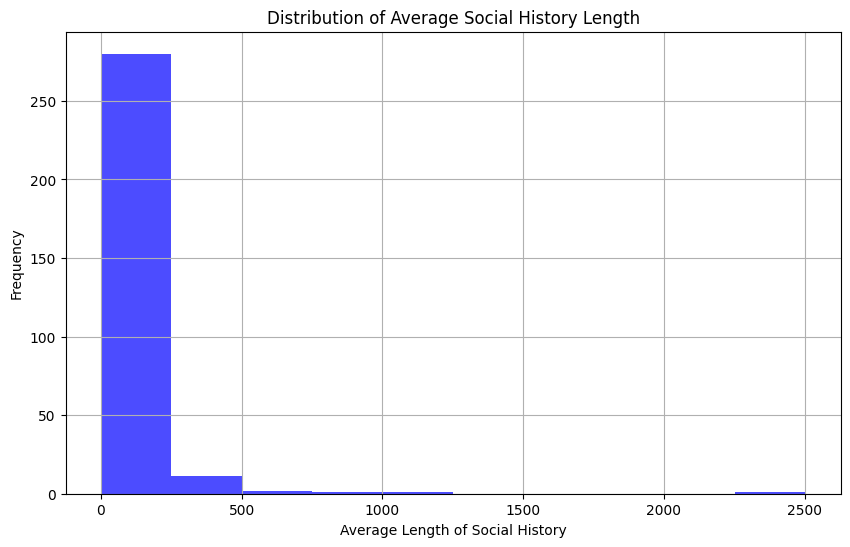

In [22]:
import matplotlib.pyplot as plt

# Sample data, replace df with your actual DataFrame from the process_folder function
# df = pd.DataFrame({'SH Average Length': [100, 150, 120, 130, 140]})

# make a list of every social history length
shLen = []

for patient in df:
  shLen = shLen + [df[patient]['SH Average Len']]


# Plotting the distribution of social history lengths
plt.figure(figsize=(10, 6))
plt.hist(shLen, bins=10, color='blue', alpha=0.7)
plt.title('Distribution of Average Social History Length')
plt.xlabel('Average Length of Social History')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


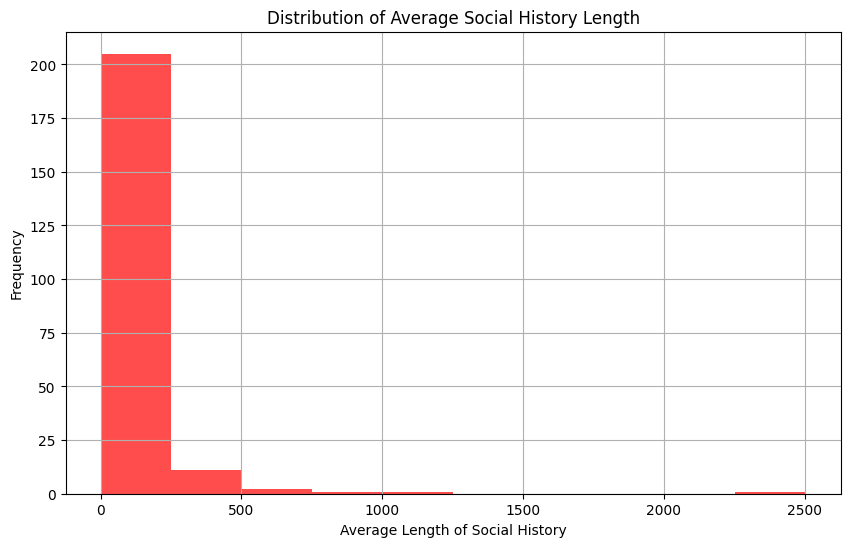

In [23]:
# make a list of every social history length WITHOUT 0
shLen = []

for patient in df:
  if df[patient]['SH Average Len'] > 0:
    shLen = shLen + [df[patient]['SH Average Len']]


# Plotting the distribution of social history lengths
plt.figure(figsize=(10, 6))
plt.hist(shLen, bins=10, color='red', alpha=0.7)
plt.title('Distribution of Average Social History Length')
plt.xlabel('Average Length of Social History')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

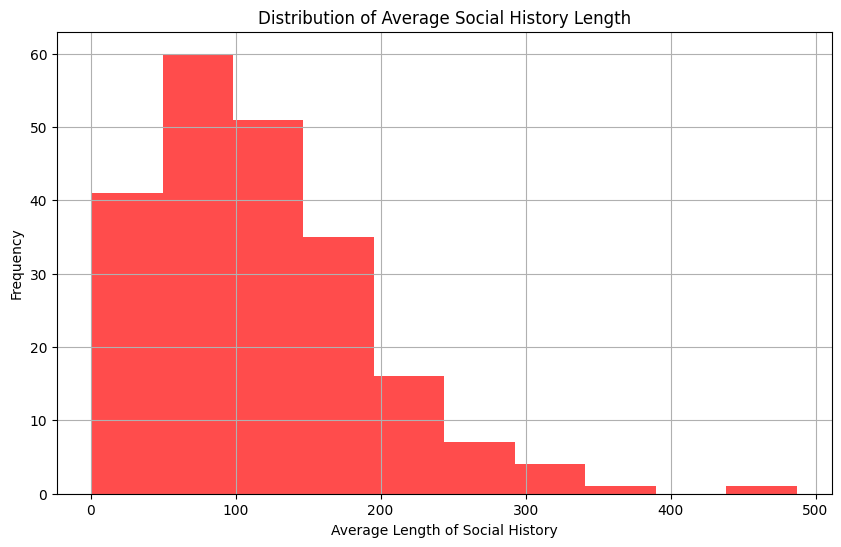

In [25]:
# make a list of every social history length WITHOUT 0
shLen = []

for patient in df:
  if df[patient]['SH Average Len'] > 0 and df[patient]['SH Average Len'] < 500:
    shLen = shLen + [df[patient]['SH Average Len']]


# Plotting the distribution of social history lengths
plt.figure(figsize=(10, 6))
plt.hist(shLen, bins=10, color='red', alpha=0.7)
plt.title('Distribution of Average Social History Length')
plt.xlabel('Average Length of Social History')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()